In [1]:
# This line is a convenience to import most packages you'll need. You may need to import others (e.g. random and cmath)
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, cmath,math
from IPython.display import Audio
 
# This line makes sure your plots happen IN the webpage you're building, instead of in separate windows.
%matplotlib inline

In [2]:
from scipy.fftpack import fft
from scipy.signal import hann

def stft(signal, window_size, hop_size, window_type = 'hann'):
    """
    Computes the short term fourier transform of a 1-D numpy array, where the array 
    is windowed into a set of subarrays, each of length window_size. The distance between
    window centers (in samples) is given by hop_size. The type of window applied is
    determined by window_type. This returns a 2-D numpy array where the ith column
    is the FFT of the ith window. Each column contains an array of complex values.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    window_type: a string specifying one of two "hann" or "rectangular"
    
    Returns
    -------
    a 2D numpy array of complex numbers where the array column is the FFT of the ith window,
    and the jth element in the ith column is the jth frequency of analysis.
    """
    
    # figure out how many hops
    length_to_cover_with_hops = len(signal) - window_size;
    assert (length_to_cover_with_hops >= 0), "window_size cannot be longer than the signal to be windowed"
    num_hops = int(1 + np.floor(length_to_cover_with_hops/hop_size));
    
    # make our window function
    if (window_type == 'hann'):
        window = sp.signal.hann(window_size, sym=False)
    else:
        window = np.ones(window_size) # rectangular window
    
    stft = [0]*num_hops
    # fill the array with values 
    for hop in range(num_hops):
        start = hop*hop_size
        end = start + window_size
        unwindowed_sound = signal[start:end]
        windowed_sound =  unwindowed_sound * window
        stft[hop]= fft(windowed_sound, window_size) 
    return np.array(stft).T

In [3]:
from scipy.fftpack import ifft

def istft(X, hop_size):
    """
    Takes a 2-D numpy array representing an STFT of some signal, where stft[i,j] is the jth
    frequency of analysis in the FFT of the ith window. 
    Performs an inverse FFT on each window and then does overlap & add resynthesis to rebuild 
    the original signal the STFT was built from.
    
    Input Parameters
    ----------------
    X: a 2-D numpy array of complex numbers representing an STFT, where the ith 
    column is the FFT of the ith window, and the jth row is the jth frequency of analysis.
        
    hop_size: an integer specifying the number of samples between the start of adjacent windows.
        
    Returns
    -------
    a 1-d numpy array of (possibly complex) values representing the original signal used to make X
    """
    
    # make an empty signal of the appropriate length
    window_size,num_hops = X.shape
    signal_length = (num_hops-1)*hop_size + window_size 
    signal = np.zeros(signal_length,dtype='complex');
    
    #fill the signal
    for n in range(num_hops):
        start = n * hop_size
        end = start + window_size
        signal[start:end] = signal[start:end] + ifft(X[:,n])
    return signal

In [4]:
def plt_spectrogram(X,win_length, hop_size, sample_rate, zoom_x=None, zoom_y=None,tick_labels='time-freq'):
    """
    Plots the log magnitude spectrogram.
    
    Input Parameters:
    ------------------
    X: 2D complex numpy array containing the stft values. Rows correspond to frequency bins and columns to time frames.
    win_length: the length of the analysis window
    hop_size: the hop size between adjacent windows
    sample_rate: sampling frequency
    tick_labels: the type of x and y tick labels, there are two options:
                 'time-freq': shows times (sec) on the x-axis and frequency (Hz) on the y-axis (default)
                 'bin-frame': shows time frame numbers on the x-axis and frequency bin numbers on the y-axis
                
    zoom_x: 1 by 2 numpy array containing the range of values on the x-axis, e.g. zoom_t = np.array([x_start,x_end])
    zoom_y: 1 by 2 numpy array containing the range of values on the y-axis, e.g. zoom_f = np.array([y_start,y_end])
    
    
    Returns:
    ---------
    times: 1D real numpy array containing time instances corresponding to stft frames
    freqs: 1D real numpy array containing frequencies of analyasis up to Nyquist rate
    2D plot of the magnitude spectrogram
    """
    
    # Find the size of stft
    Nf,Nt = np.shape(X)
    
    # Compute the log magnitude spectrogram
    X = 20*np.log10(np.abs(X))

    # Extract the lower half of the spectrum for each time frame
    X = X[0:int(Nf/2)+1] # make sure to include both 0 and Nyquist frequency
    Nf = np.shape(X)[0]
        
    # Generate time vector for plotting
    times = (hop_size/float(sample_rate))*np.arange(Nt)
    
    # Generate frequency vector for plotting
    freqs = (float(sample_rate)/win_length)*np.arange(Nf)
    
    # Generate time and frequency matrices for pcolormesh
    times_matrix,freqs_matrix = np.meshgrid(times,freqs)
    
    # Plot the log magnitude spectrogram
    plt.title('Log magnitude spectrogram')
    if tick_labels == 'bin-frame':
        plt.pcolormesh(X)
        plt.xlabel('Time-frame Number')
        plt.ylabel('Frequency-bin Number')
    else:
        plt.pcolormesh(times_matrix,freqs_matrix,X)
        plt.xlabel('Time (sec)')
        plt.ylabel('Frequency (Hz)')

        
    # Zoom in on the plot if specified
    if zoom_x is None and zoom_y is None:
        plt.axis('tight')
        
    if zoom_x is not None:
        plt.xlim(zoom_x)
        
    if zoom_y is not None:
        plt.ylim(zoom_y)
        
    return    

C:\Users\tinouye\Miniconda3\envs\eecs352\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


(266581,)
(1025, 521)


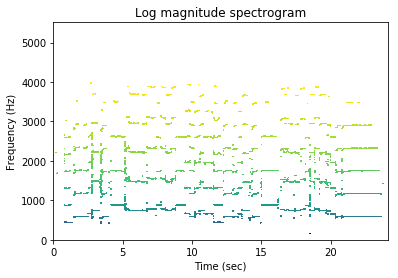

In [59]:
x,sr = librosa.load("trumpet.wav")
Audio(x,rate=sr)
pitches, magnitudes = librosa.piptrack(x,sr=sr)

final = np.max(pitches, axis=0)

stftX = stft(x, 2048, 1024, window_type = 'hann')

plt_spectrogram(pitches,2048, 1024, sr, zoom_x=None, zoom_y=None,tick_labels='time-freq')

xaxis = np.linspace(0,521,521)
print(np.shape(x))
print(np.shape(pitches))
#plt.scatter(xaxis,final)

uhh = istft(pitches,1024)



In [60]:
def getFundFreqs(pitchesArr):
    fundFreqArr = np.array([])
    transformedPitches = pitchesArr.T

    for ind, time in enumerate(transformedPitches):
        for ind2, freq in enumerate(time):
            if freq>0:
                fundFreqArr = np.append(fundFreqArr,freq)
                break
    return fundFreqArr

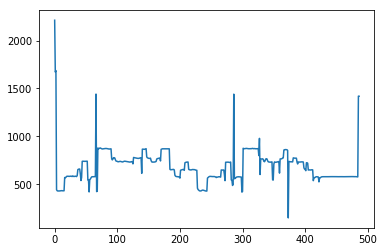

In [61]:
test = getFundFreqs(pitches)
plt.plot(test)



(1025, 850)
(1025,)


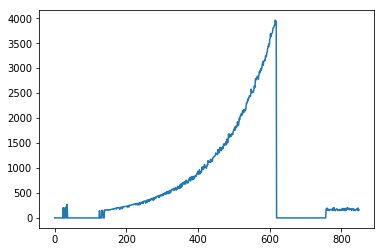

In [6]:

final = np.zeros(850)
print(np.shape(pitches))
xval = np.zeros(1)
yval = np.zeros(1)

transf = pitches.T


for ind, t in enumerate(transf):
    for ind2, f in enumerate(t):
        if f>0:
            final[ind] = f
            break


print(np.shape(pitches[:,0]))
#plt.scatter(xval,yval)
plt.plot(final)
#plt.pcolor(pitches[:400,:])
            

ValueError: x and y must be the same size

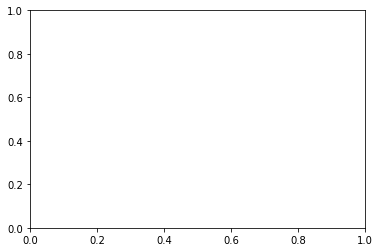

In [7]:
#plt.plot(final)
plt.scatter(np.linspace(0,521,521),final)

(850,)


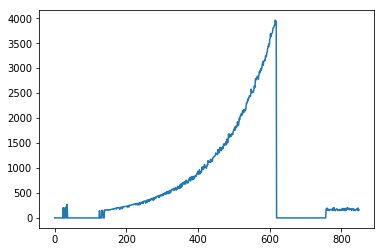

In [9]:
plt.plot(final)
print(np.shape(final))

In [10]:
def findNearestNote(freq,scale):
    noteIndex = np.argmin(np.abs(scale-freq))
    #print(freq)
    return scale[noteIndex]

In [11]:
def getBaseFreq(freq):
    #multiplier = np.zeros(np.shape(freqArr)[0])
    #for i, freq in enumerate(freqArr):
    multiplier = 0
    while(freq>61.73541):
        #freqArr[i] = freqArr[i]/2
        freq = freq/2
        multiplier += 1
    return freq, multiplier

In [12]:
def getNotesInKeyOf(key):
    allNotes = np.zeros(12)
    allNotes[0] = 32.70320
    allNotes[1] = 34.64783
    allNotes[2] = 36.70810
    allNotes[3] = 38.89087
    allNotes[4] = 41.20344
    allNotes[5] = 43.65353
    allNotes[6] = 46.24930
    allNotes[7] = 48.99943
    allNotes[8] = 51.91309
    allNotes[9] = 55.0
    allNotes[10] = 58.27047
    allNotes[11] = 61.73541
    
    output = np.zeros(7)
    output[0] = allNotes[0]
    output[1] = allNotes[2]
    output[2] = allNotes[4]
    output[3] = allNotes[5]
    output[4] = allNotes[7]
    output[5] = allNotes[9]
    output[6] = allNotes[11]
    
    return output

In [73]:
def quantizeNotes(inputArr, key):
    scale = getNotesInKeyOf(key)
    #lowNotes, octaveMultiplier = getLowNotes(inputArr)
    quantizedArr = np.zeros(np.shape(inputArr)[0])
    for i,sample in enumerate(inputArr):
        lowNote, octave = getBaseFreq(sample)
        
        quantizedArr[i] = findNearestNote(lowNote,scale)*np.power(2,octave)
    
    return quantizedArr

In [14]:
def findBeatsPerHop(bpm,hopSize,sr):
    return ((1/sr)*hopSize)/(60/bpm)
    

In [15]:
def timeFreqToMIDI(notesArr, hopSize, bpm, sr):
    #Take quantized time frequency and convert to midi output
    #For each note, look at the previous note. If it's the same note, add to its run time.
    #If it's a different note that note is done so add it to the output with its start and end time.
    #Reset the start time, length counter, and value of current note
    
    MIDIArr = np.zeros((0,4))
    
    lastNote = 0
    noteStartTime = 0
    currentNoteLen = 0
    
    emptyNote = 0
    noteVelocity = 100
    
    beatsPerHop = findBeatsPerHop(bpm,hopSize,sr)
    
    lastNote = notesArr[0]
    currentNoteLen += beatsPerHop
    for note in notesArr[1:]:
        if(note==lastNote):
            currentNoteLen += beatsPerHop
        else:
            MIDIArr.append(MIDIArr,[[lastNote,noteVelocity,noteStartTime,noteStartTime+currentNoteLen]],axis=0)
            lastNote = note
            noteStartTime = noteStartTime+currentNoteLen
            currentNoteLen = beatsPerHop
    MIDIArr.append(MIDIArr,[[lastNote,noteVelocity,noteStartTime,noteStartTime+currentNoteLen]],axis=0)

In [76]:
def audioToMIDI(audio,sr,bpm):
    MIDIBinSize = 1024 #placeholder
    #Window size = next-next highest power of 2, so that overlap is always >half
    windowSize = int(np.power(2,1+np.ceil(np.log2(MIDIBinSize))))
    pitches, magnitudes = librosa.piptrack(audio,sr=sr,n_fft=windowSize,hop_length=MIDIBinSize)
    melody = getFundFreqs(pitches)
    
    quantized = quantizeNotes(melody,"C")
    return quantized

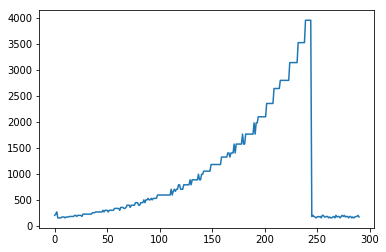

In [79]:
x,sr = librosa.load("sinesweep_recording.wav")
out = audioToMIDI(x,sr,120)
plt.plot(out)


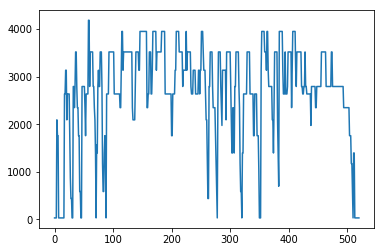

In [75]:

quantized = quantizeNotes(final,"c")
plt.plot(quantized)

In [54]:
x, sr = librosa.load("testvoice.wav")

NoBackendError: 

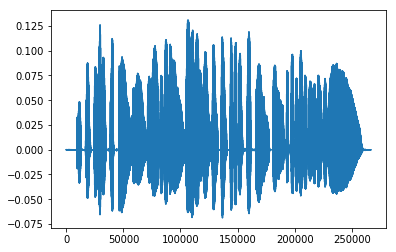

In [53]:
plt.plot(x)